In [406]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

In [407]:
# Some definitions
STOCKS = ['F', 'GM', 'TSLA']
START_DATE = '2011-01-01'
START_VAL = '2020-01-01'
START_TEST = '2021-01-01'
END_DATE = '2021-12-01'
DATA_DIR = '../data'
THR_PCT_PRICE_CHANGE = 0.05
QUERIES = {
    'TSLA': 'Tesla Motors Inc',
    'F': 'Ford Motor Co',
    'GM': 'General Motors'  
}

In [408]:
def load_stock_data(stock):
    # Read the dataset
    dfs = pd.read_csv(os.path.join(DATA_DIR, f'{stock}.csv'), parse_dates=['Date'])
    dfs['stock'] = stock
    dfs = dfs[(dfs['Date'] >= START_DATE) & (dfs['Date'] < END_DATE)].copy()
    dfs = dfs.sort_values('Date')
    
    # Compute the target
    dfs['pct'] = dfs['Close'].pct_change()
    dfs['is_signif'] = (dfs['pct'].abs() > THR_PCT_PRICE_CHANGE).astype(int)
    dfs = dfs.dropna(subset=['is_signif'])
    
    # Target features
    for d in [5, 30]:
        dfs[f'target_encoded_{d}'] = dfs['is_signif'].shift(1).rolling(d).mean().fillna(0)
    dfs[f'target_encoded_365'] = dfs['is_signif'].shift(1).expanding().mean()
    
    # Additional pct_change features
    for p in [5, 30]:
        dfs[f'pct{p}'] = dfs['Close'].shift(1).pct_change(periods=(p-1))
    
    for l in [1, 2]:
        dfs[f'pct_lag{l}'] = dfs['Close'].shift(1).pct_change(periods=(l))
        
    # Volatility features
    dfs['volatility'] = (dfs['High'] - dfs['Low']) / dfs['Open']
    for p in [5, 30]:
        dfs[f'volatility{p}'] = dfs['volatility'].shift(1).rolling(p).mean()
    
    # Calendar
    dfs['weekday'] = dfs['Date'].dt.weekday
    dfs['month'] = dfs['Date'].dt.month
    
    return dfs

In [409]:
stock_dfs = []
for stock in STOCKS:
    print(stock)
    stock_dfs.append(load_stock_data(stock))

df_price = pd.concat(stock_dfs)
df = df_price.set_index('Date').sort_index()

F
GM
TSLA


In [410]:
df_nyt = pd.read_csv(os.path.join(DATA_DIR, 'HL_source3_nytimeshl_v3_withSentiment.csv'), parse_dates=['date'])
df_nyt['date'] = df_nyt['date'].dt.tz_localize(None)
df_nyt['hour'] = df_nyt['date'].dt.hour
df_nyt['weekday'] = df_nyt['date'].dt.weekday
df_nyt['offset_day'] = ((df_nyt['hour'] >= 19) & (~df_nyt['weekday'].isin([5, 6]))).astype(int)
df_nyt['offset_saturday'] = 2 * (df_nyt['weekday'] == 5).astype(int)
df_nyt['offset_day'] += df_nyt['offset_saturday']
df_nyt['offset_sunday'] = 1 * (df_nyt['weekday'] == 6).astype(int)
df_nyt['offset_day'] += df_nyt['offset_sunday']
days_to_shift = pd.TimedeltaIndex(df_nyt['offset_day'], unit='D')
df_nyt['new_date'] = df_nyt['date'] + days_to_shift
df_nyt['Date'] = df_nyt['new_date'].dt.normalize()

In [411]:
headlines_dfs = []
for stock, tag in QUERIES.items():
    print(stock)
    for i in range(10):
        df_nyt[f'match_tag{i}'] = (df_nyt[f'tag{i}'].astype(str) == tag).astype(int)
    headlines = df_nyt[df_nyt[[f'match_tag{i}' for i in range(10)]].sum(axis=1) > 0].copy()
    print(headlines.shape)
    headlines = headlines.groupby('Date')[['positive', 'negative']].agg(
        {
            'positive': ['mean', 'min', 'max'],
            'negative': ['mean', 'min', 'max', 'count'],
        }
    ).reset_index()
    headlines.columns = ['Date'] + \
        ['_'.join([sent, stat]) for sent in ['positive', 'negative'] for stat in ['mean', 'min', 'max']] + \
        ['n_headlines']
    headlines['stock'] = stock
    headlines_dfs.append(headlines)
headlines = pd.concat(headlines_dfs)

TSLA
(592, 39)
F
(1024, 39)
GM
(1484, 39)


In [412]:
df = df.reset_index().merge(headlines, on=['Date', 'stock'], how='left')
df['n_headlines'] = df['n_headlines'].fillna(0)

In [413]:
df.isnull().sum(axis=0)

Date                     0
Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
stock                    0
pct                      3
is_signif                0
target_encoded_5         0
target_encoded_30        0
target_encoded_365       3
pct5                    15
pct30                   90
pct_lag1                 6
pct_lag2                 9
volatility               0
volatility5             15
volatility30            90
weekday                  0
month                    0
positive_mean         6322
positive_min          6322
positive_max          6322
negative_mean         6322
negative_min          6322
negative_max          6322
n_headlines              0
dtype: int64

In [414]:
# Get dummies for the stock
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['stock', 'weekday', 'month'])
df = df.set_index('Date').sort_index()

In [415]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'pct',
       'is_signif', 'target_encoded_5', 'target_encoded_30',
       'target_encoded_365', 'pct5', 'pct30', 'pct_lag1', 'pct_lag2',
       'volatility', 'volatility5', 'volatility30', 'positive_mean',
       'positive_min', 'positive_max', 'negative_mean', 'negative_min',
       'negative_max', 'n_headlines', 'stock_F', 'stock_GM', 'stock_TSLA',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [416]:
# Features
FEATURES = [
    'target_encoded_5',
    'target_encoded_30',
    'target_encoded_365',
    'pct5',
    'pct30',
    'volatility5',
    'volatility30',
    'stock_F', 'stock_GM', 'stock_TSLA',
    'positive_mean', 'positive_max', 'positive_min',
    'negative_mean', 'negative_max', 'negative_min',
    'n_headlines'
]

TARGET = 'is_signif'

In [417]:
# Split
df_train = df[: START_VAL]
df_val = df[START_VAL: START_TEST]
df_test = df[START_TEST: ]

# LGBM datasets
dtrain = lgb.Dataset(df_train[FEATURES], label=df_train[TARGET])
dval = lgb.Dataset(df_val[FEATURES], label=df_val[TARGET])
dtest = lgb.Dataset(df_test[FEATURES], label=df_test[TARGET])

In [418]:
def metrics(y_true, y_pred, thr=0.5):
    y_pred_bin = (np.clip(y_pred, 0., 1.) > thr).astype(float)    
    return {
        'Roc Auc': roc_auc_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred_bin),
        'Recall': recall_score(y_true, y_pred_bin),        
        'Precision': precision_score(y_true, y_pred_bin),
    }

In [419]:
LGBM_PARAMETERS = {
    'objective': 'binary',
    'is_unbalance': True,
    'boost_from_average': False,
    'learning_rate': 0.002,
    'num_leaves': 50,
    'num_iterations': 2000,
    'lambda_l1': 10.,
    'lambda_l2': 20.,
    'metric': 'auc',
    'num_threads': 4,
    'seed': 1987
}

model = lgb.train(
    LGBM_PARAMETERS,
    dtrain,
    valid_sets=[dval],
    verbose_eval=50,
    early_stopping_rounds=400
)

Training until validation scores don't improve for 400 rounds.


/Users/scasasso/LightGBM/python-package/lightgbm/engine.py:147: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's auc: 0.735359
[100]	valid_0's auc: 0.727197
[150]	valid_0's auc: 0.736806
[200]	valid_0's auc: 0.738079
[250]	valid_0's auc: 0.74065
[300]	valid_0's auc: 0.741604
[350]	valid_0's auc: 0.742271
[400]	valid_0's auc: 0.744217
[450]	valid_0's auc: 0.746811
[500]	valid_0's auc: 0.746283
[550]	valid_0's auc: 0.746595
[600]	valid_0's auc: 0.747015
[650]	valid_0's auc: 0.747201
[700]	valid_0's auc: 0.747856
[750]	valid_0's auc: 0.747916
[800]	valid_0's auc: 0.74728
[850]	valid_0's auc: 0.747304
[900]	valid_0's auc: 0.746265
[950]	valid_0's auc: 0.74591
[1000]	valid_0's auc: 0.744151
[1050]	valid_0's auc: 0.743544
[1100]	valid_0's auc: 0.743436
[1150]	valid_0's auc: 0.742613
Early stopping, best iteration is:
[768]	valid_0's auc: 0.748595


In [420]:
y_pred_test = model.predict(df_test[FEATURES].values)
y_test = df_test[TARGET].values
metrics(y_test, y_pred_test, 0.5)

{'Roc Auc': 0.6436753634475597,
 'F1': 0.21100917431192656,
 'Recall': 0.4791666666666667,
 'Precision': 0.13529411764705881}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

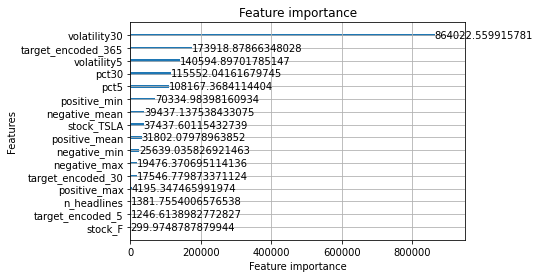

In [421]:
fig, ax = plt.subplots()
lgb.plot_importance(model, ax=ax, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

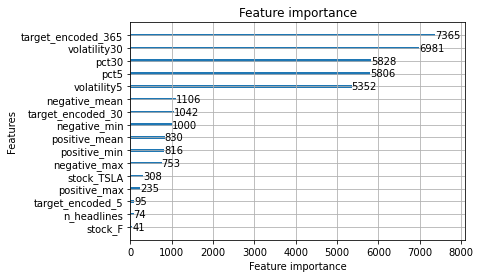

In [422]:
fig, ax = plt.subplots()
lgb.plot_importance(model, ax=ax, importance_type='split')